In [25]:
import duckdb
from glob import glob
import re
from os.path import basename

duckdb.sql("""
create or replace table coins (
    ts timestamptz,
    symbol text,
    close float,
    volume int64
);
create index ts_coins on coins(ts);
create index sym_coins on coins(symbol);
create unique index sym_ts_coins on coins(symbol, ts);
""")

files = glob('pd-data/*.parquet')
coins = list(map(lambda f: re.search(r'(.+)\.parquet', basename(f)).group(1), files))

for tick in coins:
    f = f'pd-data/{tick}.parquet'
    duckdb.read_parquet(f)
    duckdb.execute('delete from coins where symbol = ?', [tick])
    duckdb.execute(f'''
    insert into coins
    select distinct on (timestamp)
        timestamp as ts,
        asset as symbol,
        price as close,
        total_volume as volume
    from '{f}'
    order by timestamp,price
    ''')

┌──────────────────────────┬─────────┬─────────┬────────┐
│            ts            │ symbol  │  close  │ volume │
│ timestamp with time zone │ varchar │  float  │ int64  │
├──────────────────────────┼─────────┼─────────┼────────┤
│ 2010-11-07 00:00:00+08   │ btc     │ 0.11501 │   8881 │
│ 2010-11-08 00:00:00+08   │ btc     │   0.132 │  15603 │
│ 2010-11-09 00:00:00+08   │ btc     │  0.1503 │   7212 │
│ 2010-11-10 00:00:00+08   │ btc     │  0.1877 │   5704 │
│ 2010-11-11 00:00:00+08   │ btc     │  0.1731 │    871 │
│ 2010-11-12 00:00:00+08   │ btc     │    0.19 │   7737 │
│ 2010-11-13 00:00:00+08   │ btc     │  0.1989 │   4359 │
│ 2010-11-14 00:00:00+08   │ btc     │  0.1925 │   3243 │
│ 2010-11-15 00:00:00+08   │ btc     │  0.1955 │   1663 │
│ 2010-11-16 00:00:00+08   │ btc     │  0.1938 │   6576 │
├──────────────────────────┴─────────┴─────────┴────────┤
│ 10 rows                                     4 columns │
└───────────────────────────────────────────────────────┘



In [119]:
duckdb.sql("""
create or replace table metrics (
    ts timestamptz,
    symbol text,
    logret float,
    relvol float,
    lags float[14]
);
create index ts_metrics on metrics(ts);
create index sym_metrics on metrics(symbol);
create unique index sym_ts_metrics on metrics(symbol, ts);
""")


duckdb.execute('''
with total_volume as (
    select
        ts,
        sum(volume) as v
    from coins
    group by ts
), rel_volume as (
    select
        coins.ts,
        symbol,
        volume / total_volume.v as relvol
    from coins
    join total_volume on coins.ts = total_volume.ts
), returns as (
    select
        ts,
        symbol,
        close / lag(close) over (partition by symbol order by ts) as ret
    from coins
), log_returns as (
    select
        ts,
        symbol,
        ln(ret) as logret
    from returns
), lags as (
    select
        ts,
        symbol,
        [
            sum(logret) over (partition by symbol order by ts rows between 1 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 2 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 3 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 4 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 5 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 6 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 7 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 8 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 9 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 10 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 11 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 12 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 13 preceding and 0 following),
            sum(logret) over (partition by symbol order by ts rows between 14 preceding and 0 following)            
        ] as lags
    from log_returns
)
insert into metrics
select
    rv.ts,
    rv.symbol,
    lr.logret,
    rv.relvol,
    l.lags
from rel_volume rv
join lags l on rv.ts = l.ts and rv.symbol = l.symbol
join log_returns lr on rv.ts = lr.ts and rv.symbol = lr.symbol
''')

In [232]:
# hyperparameters
# lag
# folio size/cutoff
# tracking error


import polars as pl
import numpy as np
import functools as fc
import matplotlib.pyplot as plt
import pandas as pd

index = duckdb.sql('select distinct ts from metrics order by ts asc''').df()

res = pd.DataFrame({
    'logret': [0.0 for _ in range(0, len(tss['ts']))],
    'weights': [{} for _ in range(0, len(tss['ts']))]
}, index=index.ts)

for ts in index.ts:
    m = duckdb.execute('''
        select
            ts,
            symbol,
            relvol,
            logret,
            lags[2] as lag
        from metrics
        where ts = ?
          and symbol in ('btc','ada','eth')
        order by relvol desc, relvol desc
    ''', [ts]).df().set_index('ts')
    
    prev_w = res.iloc[res.index.get_loc(ts)-1].weights
    
    cumret = fc.reduce(
        lambda acc,c: acc + m[m.symbol == c[0]].iloc[0].logret * c[1],
        filter(lambda c: not m[m.symbol == c[0]].empty, prev_w.items()),
        0)
    
    weights = dict(map(
        lambda r: [r[1]['symbol'], r[1]['relvol']],
        m[(m.lag > 0.0) & (m.relvol > 0.0)].iterrows()
    ))
    weights = dict(map(lambda p: [p[0], p[1] / sum(weights.values())], weights.items()))
    res.loc[ts, ['logret','weights']] = [cumret, weights]

<Axes: xlabel='ts'>

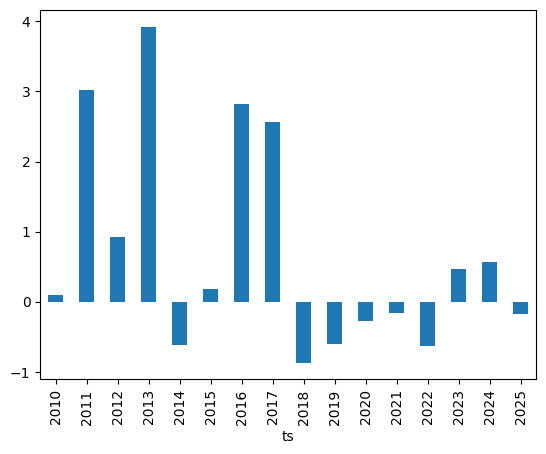

In [233]:
df = res.join(
    duckdb.execute('''
        select
            ts,
            logret as btc
        from metrics
        where symbol = 'btc'
        order by ts asc
    ''').df().set_index('ts'),
    on='ts',
    how='inner')

w = df.groupby(df.index.year)
#res1['ir'] = (res1.logret - res1.btc) / res1.logret.expanding().sum()
#res1['bench'] = res1.btc.expanding().sum()

#plt.plot(res1.index, res1.cumret, label='momentum', color='blue')
#plt.plot(res1.index, res1.bench, label='benchmark', color='orange')

w.logret.sum().plot(kind='bar')